<a href="https://colab.research.google.com/github/pkshcherbakov/Data_Science/blob/main/LTR/RankNet_MSRANK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost optuna -q
import pandas as pd
import numpy as np
from catboost.datasets import msrank_10k
from sklearn.metrics import ndcg_score
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import optuna
from itertools import combinations
from sklearn.preprocessing import StandardScaler

In [8]:
def scale_features_in_query_groups(inp_feat_array, inp_query_ids):
    """
    Scale the features within query groups using the StandardScaler.

    This function scales the features within each query group separately
    using the StandardScaler from scikit-learn. The features are scaled
    to have zero mean and unit variance within each query group.

    Args:
        inp_feat_array (numpy.ndarray): Input feature matrix with shape (num_samples, num_features).
        inp_query_ids (numpy.ndarray): Query IDs corresponding to each sample in inp_feat_array.

    Returns:
        numpy.ndarray: Scaled feature matrix with the same shape as inp_feat_array.
    """
    for cur_id in np.unique(inp_query_ids):
        mask = inp_query_ids == cur_id
        tmp_array = inp_feat_array[mask]
        scaler = StandardScaler()
        inp_feat_array[mask] = scaler.fit_transform(tmp_array)

    return inp_feat_array

def prepare_data():
    '''
    Preprocesses the MSRank dataset and prepares it for training and testing.

    Returns:
    list: A list containing the following arrays/variables:
        - X_train (numpy.ndarray): Training feature matrix.
        - y_train (numpy.ndarray): Training relevance labels.
        - query_ids_train (numpy.ndarray): Query IDs for training data.
        - X_test (numpy.ndarray): Testing feature matrix.
        - y_test (numpy.ndarray): Testing relevance labels.
        - query_ids_test (numpy.ndarray): Query IDs for testing data.
    '''
    train_df, test_df = msrank_10k()
    query_ids_train = train_df[1].values.astype(int)
    X_train = train_df.drop([0, 1], axis=1).values
    X_train = scale_features_in_query_groups(X_train, query_ids_train)
    X_train = torch.FloatTensor(X_train)

    y_train = torch.FloatTensor(train_df[0].values)


    query_ids_test = test_df[1].values.astype(int)
    X_test = test_df.drop([0, 1], axis=1).values
    X_test = scale_features_in_query_groups(X_test, query_ids_test)
    X_test = torch.FloatTensor(X_test)

    y_test = torch.FloatTensor(test_df[0].values)


    print(f'Overall number of pages is {X_train.shape[0]} for train and {X_test.shape[0]} for test.')
    print(f'Relevance labels are {np.unique(y_train)}')
    print(f'Overall number of quries is {len(np.unique(query_ids_train))} for train and {len(np.unique(query_ids_test))} for test.')

    return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

In [9]:
class RankNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1),
        )

        self.out_activation = torch.nn.Sigmoid()

    def forward(self, input_1, input_2):
        logits_1 = self.predict(input_1)
        logits_2 = self.predict(input_2)
        logits_diff = logits_1 - logits_2
        out = self.out_activation(logits_diff)

        return out

    def predict(self, inp):
        logits = self.model(inp)
        return logits

def create_model(input_size,
                  hidden_size):
    torch.manual_seed(0)
    net = RankNet(input_size, hidden_size)
    return net

In [13]:
def train_model(model, X_train, y_train, query_ids_train, query_ids_test, num_epochs=10, learning_rate=0.001, patience=8):
    """
    Train the model on input data.

    Args:
        model (torch.nn.Module): The model to be trained.
        X_train (numpy.ndarray): Input data for training.
        y_train (numpy.ndarray): Target values for training.
        query_ids_train (numpy.ndarray): Query identifiers for the training dataset.
        query_ids_test (numpy.ndarray): Query identifiers for the validation dataset.
        num_epochs (int, optional): Number of training epochs. Default is 10.
        learning_rate (float, optional): Learning rate for optimization. Default is 0.001.

    Returns:
        tuple: A tuple containing two lists - CE loss values for each epoch
               and average NDCG score values on the validation dataset after each epoch.
    """
    criterion = torch.nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_ndcg = float("-inf")
    best_epoch = 0
    bce_loss = []
    test_ndcg = []


    for epoch in range(int(num_epochs)):
        model.train()

        epoch_loss = 0.0

        for query_id in np.unique(query_ids_train):
              mask = query_ids_train == query_id
              query_X = X_train[mask]
              query_y = y_train[mask]

              optimizer.zero_grad()  # Zero the gradients
              num_docs = len(query_X)

              # Create pairwise combinations of document indices
              pairwise_combinations = torch.tensor(list(combinations(range(num_docs), 2)))

              # Get the document indices for each pair
              doc_indices_1 = pairwise_combinations[:, 0]
              doc_indices_2 = pairwise_combinations[:, 1]

              # Get the features for each document in the pairs
              input_1 = query_X[doc_indices_1]
              input_2 = query_X[doc_indices_2]

              logits = model(input_1, input_2)

              # Calculate labels for pairs (1 if doc 1 is more relevant, 0 otherwise)
              labels = (query_y[doc_indices_1] > query_y[doc_indices_2]).float()

              loss = criterion(logits.squeeze(), labels)
              loss.backward()
              optimizer.step()

              epoch_loss += loss.item()

        bce_loss.append(epoch_loss)

        with torch.no_grad():
            model.eval()
            ndcgs = []
            for cur_id in np.unique(query_ids_test):
                mask = query_ids_test == cur_id
                X_test_tmp = X_test[mask]

                doc_scores = model.predict(X_test_tmp)  # Predict scores for the documents

                if np.sum(mask) > 1:
                    doc_scores = doc_scores.squeeze().detach().numpy()
                    curr_ndcg = ndcg_score(y_test[mask].reshape(1, -1), doc_scores.reshape(1, -1), k=10)
                    ndcgs.append(curr_ndcg)
                else:
                    continue

            mean_ndcg = np.mean(ndcgs) if len(ndcgs) > 0 else 0.0

        test_ndcg.append(mean_ndcg)

        if mean_ndcg > best_ndcg:
            best_ndcg = mean_ndcg
            best_epoch = epoch

        if epoch - best_epoch > patience:
          break

    return bce_loss[:best_epoch + 1], test_ndcg[:best_epoch + 1]

In [14]:
X_train, y_train, query_ids_train, X_test, y_test, query_ids_test = prepare_data()

Overall number of pages is 10000 for train and 10000 for test.
Relevance labels are [0. 1. 2. 3. 4.]
Overall number of quries is 87 for train and 88 for test.


In [ ]:
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 4, 120)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 10, 300)

    model = create_model(X_train.shape[1], hidden_size)
    ce_loss, test_ndcg = train_model(model, X_train, y_train, query_ids_train, query_ids_test, num_epochs, learning_rate)
    return np.max(test_ndcg)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  150  
Best trial:  
Value:  0.511610947264055  
Params:  
    hidden_size: 6  
    learning_rate: 0.0008599979258119441  
    num_epochs: 60

In [16]:
optuna.visualization.plot_contour(study, params=['hidden_size',
                            'learning_rate',
                            'num_epochs'])

In [17]:
optuna.visualization.plot_optimization_history(study)

In [18]:
optuna.visualization.plot_slice(study)

In [19]:
optuna.visualization.plot_param_importances(study)

In [20]:
best_params = study.best_params
best_hidden_size = best_params["hidden_size"]
best_learning_rate = best_params["learning_rate"]
best_num_epochs = best_params["num_epochs"]

model = create_model(X_train.shape[1], best_hidden_size)
best_ce_loss, best_test_ndcg = train_model(model, X_train, y_train, query_ids_train, query_ids_test, best_num_epochs, best_learning_rate)

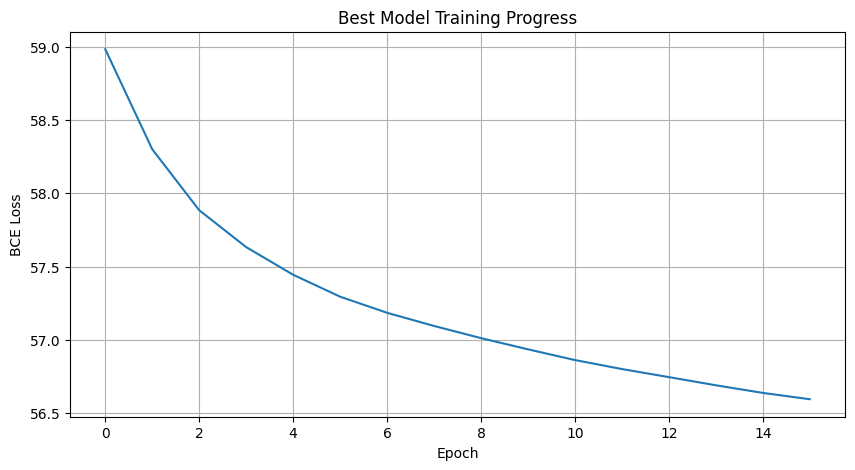

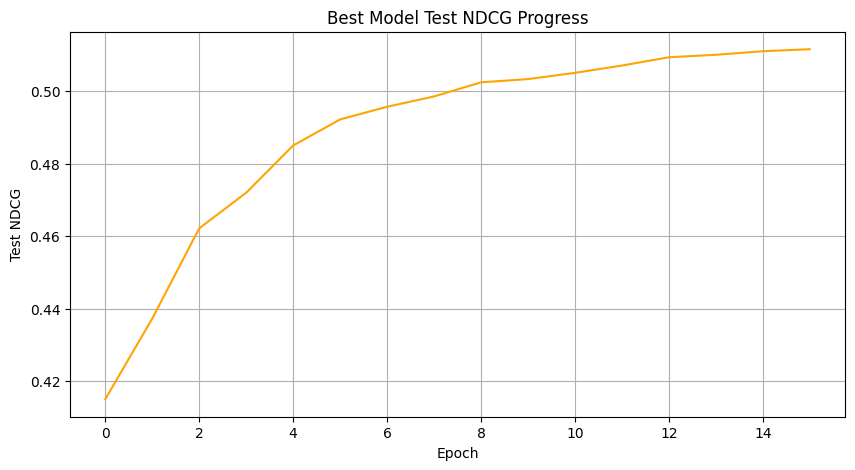

In [21]:
# BCE Loss
plt.figure(figsize=(10, 5))
plt.plot(best_ce_loss)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('Best Model Training Progress')
plt.grid(True)
plt.show()

# best_test_ndcg
plt.figure(figsize=(10, 5))
plt.plot(best_test_ndcg, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Test NDCG')
plt.title('Best Model Test NDCG Progress')
plt.grid(True)
plt.show()